# Anime Classification
## Transfer Learning : Mobilenet V2

## Dataset = animax (kirito, naruto, tanjirou)

In [ ]:
import os
print(os.listdir('../input/animax'))

In [ ]:
dataPath = '../input/animax'

In [ ]:
# Import Libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import numpy as np
import cv2
import glob
import random

from IPython.display import Image
import matplotlib.pyplot as plt

In [ ]:
TargetSize = (224,224) 
def prepare_image(filepath):
    img = cv2.imread(filepath)
    img_resized = cv2.resize(img, TargetSize, interpolation=cv2.INTER_CUBIC)
    img_result  = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    return img_result

## Prepare Data

In [ ]:
dirList = glob.glob(dataPath+'/*') # list of all directories in dataPath
dirList.sort() # sorted in alphabetical order
print(dirList)

In [ ]:
Y_data = []
for i in range(len(dirList)):
    fileList = glob.glob(dirList[i]+'/*')
    [Y_data.append(i) for file in fileList]
print(Y_data)

In [ ]:
X_data = []
for i in range(len(dirList)):
    fileList = glob.glob(dirList[i]+'/*')
    [X_data.append(prepare_image(file)) for file in fileList]
X_data = np.asarray(X_data)
print(X_data.shape)

### shuffle data

In [ ]:
## random shuffle
from sklearn.utils import shuffle
X_data, Y_data = shuffle(X_data, Y_data, random_state=0)

In [ ]:
print(Y_data)

In [ ]:
testNum = random.randint(0,len(X_data))
print(testNum)
plt.imshow(X_data[testNum])

In [ ]:
num_classes = len(dirList) 
labels = [dir.replace(dataPath+"/", "") for dir in dirList]
print(labels)

In [ ]:
equilibre = []
[equilibre.append(Y_data.count(i)) for i in range(len(dirList))]
print(equilibre)

In [ ]:
# plot the circle of value counts in dataset
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(equilibre, labels=labels, colors=['red','green','blue'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Data Normalisation

In [ ]:
# Data Normalisation
X_train = X_data / 255.0
print(X_train.shape)

In [ ]:
# One-hot encoding
Y_train = to_categorical(Y_data)
print(Y_train.shape)

## Load MobileNet v2 model & add FC-layers

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
# use MobieNet V2 as base model
base_model=MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False) 

# add Fully-Connected Layers to Model
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) # FC layer 1
x=Dense(64,activation='relu')(x)   # FC layer 2
preds=Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)
model.summary()

### show all layers (no. & name)

In [ ]:
# Check layers no. & name
for i,layer in enumerate(model.layers):
    print(i,layer.name)

### set FC-layers to trainable

In [ ]:
# set extra layers to trainable 
for layer in model.layers[:155]:
    layer.trainable=False
for layer in model.layers[155:]:
    layer.trainable=True

In [ ]:
# Compile Model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train Model (target is loss <0.01)
batch_size= 16
num_epochs = 10
history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=num_epochs)

## Save Model

In [ ]:
# Save Model
model.save('tl_animax.h5')

## Test Model

### check 1 picture per category

In [ ]:
def classify_worms(imageFile):
    testData = prepare_image(imageFile).reshape(1,224,224,3)
    testData = testData / 255.0
    predictions = model.predict(testData)
#    print(predictions[0])
    maxindex = int(np.argmax(predictions))
    print(predictions[0][maxindex],labels[maxindex])
    return labels[maxindex]

In [ ]:
imageFile=dirList[0]+'/01.jpg'
plt.imshow(prepare_image(imageFile))
classify_worms(imageFile)

In [ ]:
imageFile=dirList[1]+'/01.jpg'
plt.imshow(prepare_image(imageFile))
classify_worms(imageFile)

In [ ]:
imageFile=dirList[2]+'/01.jpg'
plt.imshow(prepare_image(imageFile))
classify_worms(imageFile)

### check entire dataset

In [ ]:
Y_pred = model.predict(X_train)
y_pred = np.argmax(Y_pred,axis=1)
#y_label= [labels[k] for k in y_pred]
cm = confusion_matrix(Y_data, y_pred)
print(cm)

## Plot Confusion Matrix

In [ ]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix(cm, 
                      normalize=False,
                      target_names = labels,
                      title="Confusion Matrix, not Normalized")

In [ ]:
print(classification_report(Y_data, y_pred, target_names=labels))

## Weighted Average Recall
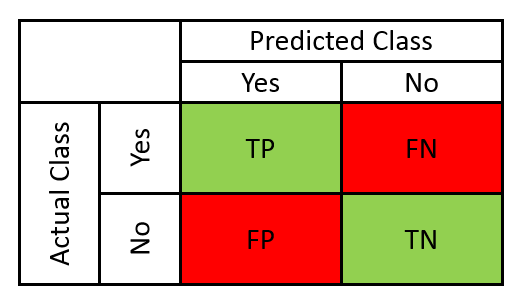
* TP : True  Positive
* FP : False Positive
* TN : True  Negative
* FN : False Negative

* Accuracy  = TP+TN / TP+FP+FN+TN
* Precision = TP / TP+FP
* Recall    = TP / TP+FN